In [0]:
# Downloading the data from Kaggle API, since it's really slow on windows

import os
username = 'arashnourimand'
key = '8958f5601aace24552a78e2c692b9297'
os.environ['KAGGLE_USERNAME'] = username 
os.environ['KAGGLE_KEY'] = key

!kaggle competitions download -c histopathologic-cancer-detection #api link copied from kaggle competition

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 91.5MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 83.8MB/s]
 99% 1.30G/1.30G [00:13<00:00, 107MB/s] 
100% 1.30G/1.30G [00:14<00:00, 98.2MB/s]
100% 4.98G/4.98G [00:43<00:00, 108MB/s] 
100% 4.98G/4.98G [00:43<00:00, 123MB/s]


In [0]:
# All of the data has been downladed, but it is still zipped. Exploratory data analysis of the 2 csv files

import pandas as pd #for the data conversions and analysis
from google.colab import drive #to access the data
from PIL import Image
from zipfile import ZipFile
import csv
import numpy as np

drive.mount('/content/gdrive')

train_labels_path = '/content/train_labels.csv.zip'
train_pics_path = '/content/train.zip'
test_pics_path = '/content/test.zip'

with ZipFile(train_labels_path) as labelzip:
    labels_csv = labelzip.namelist()
    with labelzip.open(labels_csv[0]) as myfile:
        traincsvfile = myfile.read()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Convert the extracted csv file into an actual dataframe for analysis
labels_df = pd.read_csv('train_labels.csv.zip')
# print(labels_df.describe(),'\n') # 1 = presence of cancerous tissue and 0 = non-cancerous 
cancerous= labels_df[labels_df.label == 1].count()[0]
noncancerous= labels_df[labels_df.label == 0].count()[0]
total= cancerous + noncancerous
print(f"{str(cancerous)} images with cancerous tissue, {str(noncancerous)} without cancerous tissue.")
print(f"{str(np.round((cancerous/total) * 100, 2))}% of images with cancerous tissue")
print(f"{str(np.round((noncancerous/total) * 100, 2))}% of images without cancerous tissue")

89117 images with cancerous tissue, 130908 without cancerous tissue.
40.5% of images with cancerous tissue
59.5% of images without cancerous tissue


In [0]:
# Extraction of the training images
with ZipFile(train_pics_path) as myzip:
    pics_in_zip = myzip.namelist()
    #with myzip.open(pics_in_zip[0]) as myfile:
      #  img = Image.open(myfile)
num_train_pics = len(pics_in_zip)
pics_in_zip_1= [img_name.split('.')[0] for img_name in pics_in_zip]
print(num_train_pics) #number of pictures
print(pics_in_zip[0]) #image file name

220025
019ce31cc317087ca287f66ad757776952826594.tif


# Data Preparation

In [0]:
# *** need to clean up sections a bit

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
%matplotlib inline

In [0]:
def get_dataset(pic_names_list, pics_path, labels_df):
  '''
    Function to generate the dataset given a list of pictures.

    Inputs:
      pic_names_list: list of names needed in the dataset, including file extension
      pics_path: path to where the pictures are stored
      labels_df: dataframe storing the labels of the images with 
                 2 columns: id (picture name without file extension),
                            label (0 or 1)

    Outputs: a tensor dataset with the specified images and labels
  '''
  myzip= ZipFile(pics_path)
    
  # put images in list
  imgs= [Image.open(myzip.open(pic)) for pic in pic_names_list] 
  # make images grayscale
  imgs= [torchvision.transforms.Grayscale()(img) for img in imgs]

  # convert greyscale images to tensors
  imgs= [torchvision.transforms.ToTensor()(x) for x in imgs]
  imgs= torch.stack(imgs)

  # remove file extension from name list
  pic_names_list= [img_name.split('.')[0] for img_name in pic_names_list]

  # Create tensor for labels. Convert labels_df to dictionary first because it's faster
  labels_dict= labels_df.set_index('id').to_dict()['label']
  labels= [labels_dict[name] for name in pic_names_list]
  labels= torch.from_numpy(np.asarray(labels))

  return torch.utils.data.TensorDataset(imgs, labels)


In [0]:
# Train-validation-test split: 80-10-10
train_size= int(len(pics_in_zip) * 0.8)
val_size= int(len(pics_in_zip) * 0.1)

train_dataset= get_dataset(pics_in_zip[: train_size], train_pics_path, labels_df)
val_dataset= get_dataset(pics_in_zip[train_size : train_size + val_size], train_pics_path, labels_df)
test_dataset= get_dataset(pics_in_zip[train_size + val_size :], train_pics_path, labels_df)

# Model Building


In [0]:
class CancerDetectionV1(nn.Module):
    def __init__(self):
        super(CancerDetectionV1, self).__init__()
        self.name= "cancer_detection_v1"
        self.conv1 = nn.Conv2d(1, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 21 * 21, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 21 * 21)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [0]:
!ls "/content/gdrive/My Drive/APS360/project/cancer_detection_v1_balanced/"

In [0]:
def train(model, train_data, val_data= [], batch_size=64, learning_rate= 0.01, decay= 0, num_epochs=1, use_val= True):
    '''
      Function to train neural network. Plots the loss and accuracy training curves (per epoch) at the end of training.
      
      Inputs: model: model object to use for training
              train_data: data to train model on, should be a data loader object
              val_data: validation data, should be a data loader object. The default is an empty list, don't pass anything if not using validation data
              batch_size: batch size, default value is 64
              learning_rate: learning rate for the optimizer, default is 0.01
              decay: weight decay for the optimizer, default is 0
              num_epochs: number of epochs to train for, default is 1
              use_val: boolean for whether or not to use validation data, if False the will not calculate validation accuracy or loss
              
      Optimizer used: Adam optimizer, since it is more efficient compared to a standard stochastic gradient descent
      Loss function used: binary cross entropy loss, since this is a binary classification problem 
    '''
  
    # train_loader= train_data
#     val_loader= val_data

    train_loader= torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle= False)
    
    if use_val:  
      val_loader= torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle= False)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)

    val_loss= np.zeros(num_epochs)
    val_err= np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs) 
    train_err= np.zeros(num_epochs)
    
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        total_train_loss= 0.0
        total_train_err= 0.0
        total_epoch= 0
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass
            
            labels= labels.type_as(out)
            
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            
             # Calculate the statistics
            corr = (out > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
            
            n += 1
        
        # calculate training set loss for one epoch
        train_loss[epoch] = float(total_train_loss) / (n+1)
        # compute training error 
        train_err[epoch] = float(total_train_err) / total_epoch
        print("Train error: " + str(train_err[epoch]))

        if use_val:
          # get validation set loss for one epoch  
          val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)
          print("Validation error: " + str(val_err[epoch]))
          
        #print the epoch number, to keep track of progress during training
        print("Epoch: " + str(epoch))
        # Save the current model (checkpoint) to a file every epoch
        model_path= f"/content/gdrive/My Drive/APS360/project/{model.name}_balanced/{model.name}_bs{batch_size}_lr{learning_rate}_decay{decay}_epoch{epoch}"
        torch.save(model.state_dict(), model_path)       

    # plotting
    plt.title("Training Curve")
    plt.plot(np.arange(num_epochs), train_loss, label="Train")
    
    if use_val:
      plt.plot(np.arange(num_epochs), val_loss, label="Validation")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(np.arange(num_epochs), train_err, label="Train")
    
    if use_val:
      plt.plot(np.arange(num_epochs), val_err, label="Validation")
    
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")
    plt.legend(loc='best')
    plt.show()
  
  
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         loss: A scalar for the average loss function over the validation set
     """ 

    total_err= 0.0
    total_loss = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        imgs, labels = data
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        outputs = net(imgs)
        labels= labels.type_as(outputs)
        loss = criterion(outputs, labels)
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss
  

## Sanity check

Try to overfit on a small dataset of 100 images first

In [0]:
train_dataset_small= get_dataset(pics_in_zip[:100], train_pics_path, labels_df)

CUDA is available!  Training on GPU ...
Train error: 0.64
Epoch: 0
Train error: 0.36
Epoch: 1
Train error: 0.36
Epoch: 2
Train error: 0.36
Epoch: 3
Train error: 0.36
Epoch: 4
Train error: 0.41
Epoch: 5
Train error: 0.36
Epoch: 6
Train error: 0.36
Epoch: 7
Train error: 0.36
Epoch: 8
Train error: 0.36
Epoch: 9
Train error: 0.3
Epoch: 10
Train error: 0.4
Epoch: 11
Train error: 0.36
Epoch: 12
Train error: 0.36
Epoch: 13
Train error: 0.36
Epoch: 14
Train error: 0.39
Epoch: 15
Train error: 0.39
Epoch: 16
Train error: 0.36
Epoch: 17
Train error: 0.36
Epoch: 18
Train error: 0.36
Epoch: 19
Train error: 0.36
Epoch: 20
Train error: 0.36
Epoch: 21
Train error: 0.33
Epoch: 22
Train error: 0.3
Epoch: 23
Train error: 0.31
Epoch: 24
Train error: 0.34
Epoch: 25
Train error: 0.34
Epoch: 26
Train error: 0.3
Epoch: 27
Train error: 0.26
Epoch: 28
Train error: 0.18
Epoch: 29
Train error: 0.19
Epoch: 30
Train error: 0.25
Epoch: 31
Train error: 0.14
Epoch: 32
Train error: 0.08
Epoch: 33
Train error: 0.1
Epoch

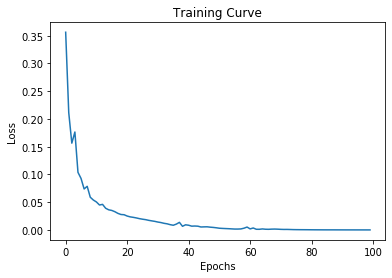

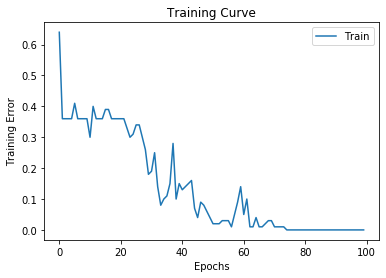

In [0]:
cancer_detec_v1= CancerDetectionV1()

use_cuda= True

if use_cuda and torch.cuda.is_available():
  cancer_detec_v1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(cancer_detec_v1, train_data= san_dataset, batch_size=100, learning_rate=0.005, num_epochs=100, use_val=False)

The model is able to overfit the small set of images in around 80 epochs.

## Actually model building

CUDA is available!  Training on GPU ...
Train error: 0.455125
Validation error: 0.448
Epoch: 0
Train error: 0.389875
Validation error: 0.38
Epoch: 1
Train error: 0.3665625
Validation error: 0.3635
Epoch: 2
Train error: 0.363375
Validation error: 0.3605
Epoch: 3
Train error: 0.361375
Validation error: 0.36
Epoch: 4
Train error: 0.36075
Validation error: 0.3605
Epoch: 5
Train error: 0.3596875
Validation error: 0.3585
Epoch: 6
Train error: 0.3581875
Validation error: 0.3595
Epoch: 7
Train error: 0.3586875
Validation error: 0.3585
Epoch: 8
Train error: 0.35675
Validation error: 0.3545
Epoch: 9
Train error: 0.3575
Validation error: 0.3585
Epoch: 10
Train error: 0.3561875
Validation error: 0.3525
Epoch: 11
Train error: 0.355625
Validation error: 0.358
Epoch: 12
Train error: 0.3555625
Validation error: 0.3535
Epoch: 13
Train error: 0.3553125
Validation error: 0.354
Epoch: 14
Train error: 0.3556875
Validation error: 0.3535
Epoch: 15
Train error: 0.3550625
Validation error: 0.353
Epoch: 16
Trai

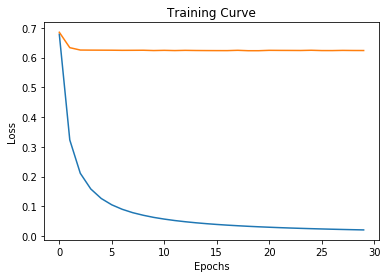

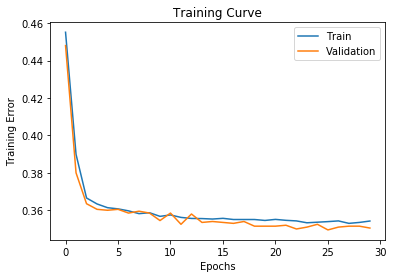

In [0]:
cancer_detec_v1= CancerDetectionV1()

use_cuda= True

if use_cuda and torch.cuda.is_available():
  cancer_detec_v1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(cancer_detec_v1, train_data= train_dataset, val_data= val_dataset, batch_size=150, learning_rate=0.005, decay= 0.01, num_epochs=30, use_val=True)

## Test

In [0]:
cancer_detec_v1= CancerDetectionV1()
model_path = f"/content/gdrive/My Drive/APS360/project/{cancer_detec_v1.name}/{cancer_detec_v1.name}_bs100_lr0.001_decay0_epoch8"
state = torch.load(model_path)
cancer_detec_v1.load_state_dict(state)

<All keys matched successfully>

In [0]:
val_loader= torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle= False)
test_loader= torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle= False)

use_cuda= True

if use_cuda and torch.cuda.is_available():
  cancer_detec_v1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

test_err, test_loss= evaluate(cancer_detec_v1, test_loader, nn.BCEWithLogitsLoss())
print(f"Test set error: {str(np.round(test_err * 100, 2))}%")

CUDA is available!  Training on GPU ...
Test set error: 17.06%


Look at false positive and false negative rates

In [0]:
# False positive rates: fpr= false positive/all positive, fnr= false negative/all negative

test_cancerous_labels= [label for img, label in iter(test_dataset) if label == 1]
test_cancerous_labels= torch.tensor(test_cancerous_labels)
test_cancerous_imgs= [img for img, label in iter(test_dataset) if label == 1]
test_cancerous_imgs= torch.stack(test_cancerous_imgs)

test_noncancerous_labels= [label for img, label in iter(test_dataset) if label == 0]
test_noncancerous_labels= torch.tensor(test_noncancerous_labels)
test_noncancerous_imgs= [img for img, label in iter(test_dataset) if label == 0]
test_noncancerous_imgs= torch.stack(test_noncancerous_imgs)

test_cancerous= torch.utils.data.TensorDataset(test_cancerous_imgs, test_cancerous_labels)
test_noncancerous= torch.utils.data.TensorDataset(test_noncancerous_imgs, test_noncancerous_labels)

test_cancerous_loader= torch.utils.data.DataLoader(test_cancerous, batch_size=100, shuffle= False)
test_noncancerous_loader= torch.utils.data.DataLoader(test_noncancerous, batch_size=100, shuffle= False)

fpr, fp_loss= evaluate(cancer_detec_v1, test_cancerous_loader, nn.BCEWithLogitsLoss())
fnr, fn_loss= evaluate(cancer_detec_v1, test_noncancerous_loader, nn.BCEWithLogitsLoss())
print(f"False positive rate: {str(np.round(fpr * 100, 2))}%")
print(f"False negative rate: {str(np.round(fnr * 100, 2))}%")

False positive rate: 26.47%
False negative rate: 12.37%


# Visualization

In [0]:
cancer_detec_v1= CancerDetectionV1()
model_path = f"/content/gdrive/My Drive/APS360/project/{cancer_detec_v1.name}/{cancer_detec_v1.name}_bs100_lr0.001_decay0_epoch8"
state = torch.load(model_path)
cancer_detec_v1.load_state_dict(state)

<All keys matched successfully>

In [0]:
pic_0= get_dataset(pics_in_zip[10:11], train_pics_path, labels_df)
pic_0_loader= torch.utils.data.DataLoader(pic_0, batch_size=1, shuffle= False)

In [0]:
for img, label in pic_0_loader:  
  print(cancer_detec_v1(img) > 0)
  print(label)


tensor([True])
tensor([1])


In [0]:
# Visualize conv1 kernels (i.e filter)
kernels = cancer_detec_v1.conv1.weight.detach()

print(kernels.shape)

torch.Size([5, 1, 5, 5])


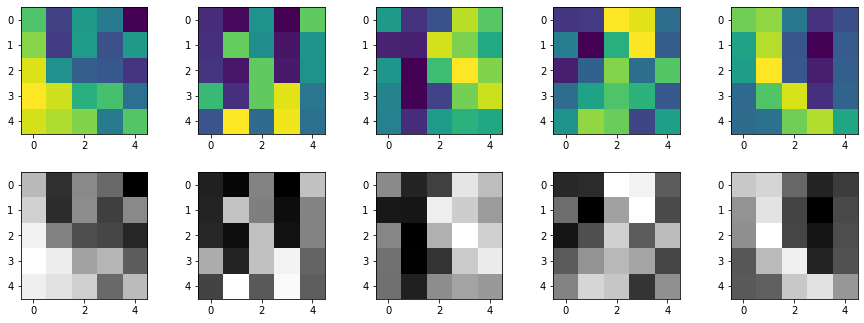

In [0]:
#this line is required if using GPU
kernels = kernels.cpu()

#display first kernel
# print(kernels[0][0])

#display all kernels
fig, axarr = plt.subplots(2, kernels.size(0), figsize=(15,15))
plt.subplots_adjust(wspace = 0.4, bottom = 0.6)
for idx in range(kernels.size(0)):
    axarr[0, idx].imshow(kernels[idx][0])
    axarr[1, idx].imshow(kernels[idx][0], cmap= 'gray')

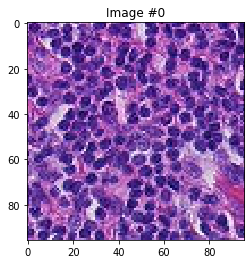

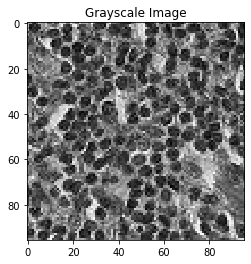

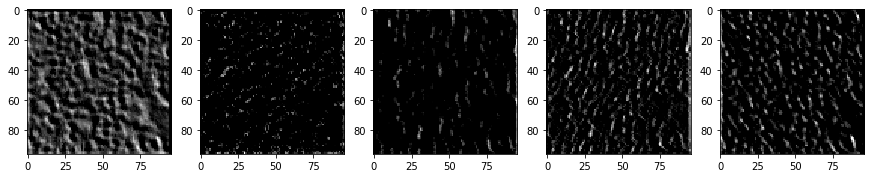

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

from PIL import Image
import requests

myzip= ZipFile(train_pics_path)

img_num= 0

# get first image in training set
img= Image.open(myzip.open(pics_in_zip[img_num])) # change this number to get a different image
# img 0 prediction: 0 label: 0
# img 10 prediction: 1 label: 1
# img100 prediction: 1 label: 1


#ensure image is np.array
img = np.array(img)

#plot original image
plt.title(f"Image #{str(img_num)}")
plt.imshow(img)
plt.show()

#increase data precision
img = img.astype(np.int16)

#convert from colour to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
  
img_gray = rgb2gray(img)

#plot grayscale image
plt.title("Grayscale Image")
plt.imshow(img_gray, cmap='gray')
plt.show()

#select kernel
k = kernels

#perform 2d convolution
imgs_k = [sg.convolve(img_gray, k[idx][0], mode='same') for idx in range(kernels.size(0))]

#normalize images
for img_k in imgs_k:  
  img_k[img_k > 255] = 255
  img_k[img_k < 0] = 0

#return to image format
for img_k in imgs_k:  
  img_k = img_k.astype(np.uint8)

#plot results of convolution
fig, axarr = plt.subplots(1, kernels.size(0), figsize=(15,15))
# plt.title("Feature Maps for Kernels")
for idx in range(len(imgs_k)):  
  axarr[idx].imshow(imgs_k[idx], cmap='gray')
  # plt.show()

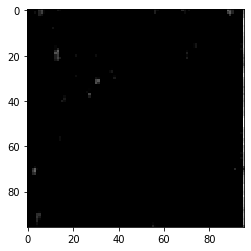

In [0]:
plt.imshow(imgs_k[2], cmap= 'gray')